# Predict energy demand in Australia

In [1]:
import os
import glob
import xarray as xr
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
# from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error
from sklearn.inspection import permutation_importance

from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from scipy.stats import pearsonr, randint, uniform
from scipy.spatial.distance import correlation

import matplotlib.pyplot as plt

### Note:

You will need to change the kernel to ml_env to use `mlxtend`

In [2]:
%cd /g/data/w42/dr6273/work/demand_model/

import functions as fn

/g/data/w42/dr6273/work/demand_model


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
path = "/g/data/w42/dr6273/work/projects/Aus_energy/"

In [137]:
region = "QLD"

### Demand

In [148]:
demand = pd.read_csv(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/energy_demand/daily_demand_2010-2020.csv",
    index_col=0,
    parse_dates=True
)

In [149]:
demand.head()

,NSW,QLD,SA,TAS,VIC
timestamp,,,,,
2010-01-01,200345.265,141770.410,30926.095,24913.555,124188.520
2010-01-02,224883.275,154139.850,35463.230,27495.375,140836.955
2010-01-03,205852.705,155611.165,33345.755,26704.820,135756.785
2010-01-04,200358.115,144340.325,33998.165,27066.485,133162.885
2010-01-05,202376.745,138618.890,33345.325,27855.585,131333.895


In [150]:
demand = demand[region]

<AxesSubplot: xlabel='timestamp'>

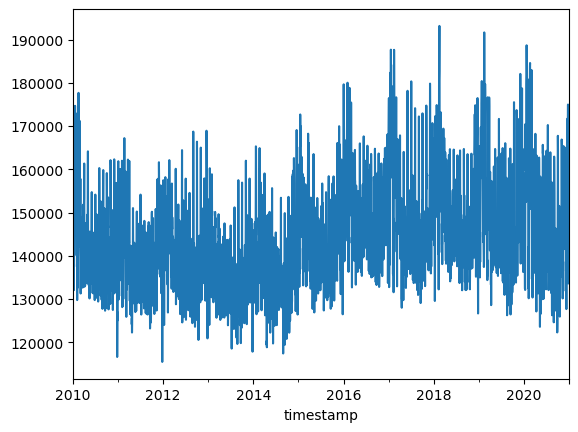

In [151]:
demand.plot()

In [205]:
dem_da = xr.DataArray(
    demand.squeeze(),
    dims=["time"],
    coords={"time": demand.index.values}
)

In [206]:
dem_da = dem_da.expand_dims({"region": [region]})

In [207]:
# dem_da = fn.detrend_dim(dem_da, "time") + dem_da.mean("time")

In [209]:
def rm_weekend(da):
    """
    Set weekend days to NaN
    """
    return da.where(da.time.dt.dayofweek < 5, drop=False)

In [210]:
dem_da = rm_weekend(dem_da)
dem_da = dem_da.dropna("time")

In [211]:
# dem_da = xr.open_dataset(
#     "/g/data/w42/dr6273/work/projects/Aus_energy/data/energy_demand/daily_demand_2010-2020_stl.nc"
# )["demand_stl"]

In [212]:
# dem_da = dem_da.sel(region=region).expand_dims({"region": [region]})

In [213]:
# dem_da.plot()

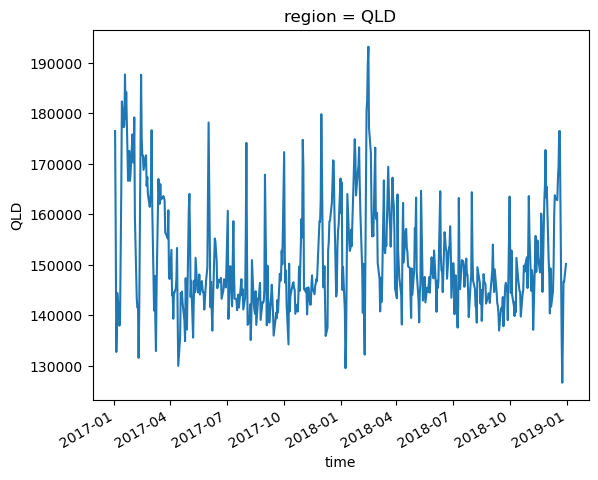

In [215]:
dem_da.sel(time=slice("2017", "2018")).plot()

### Predictors

In [216]:
files = fn.get_predictor_files("NEM", "pop_dens_mask")
files

['/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/mtpr_era5_daily_1959-2022_NEM_pop_dens_mask.nc',
 '/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/10w_era5_daily_1959-2022_NEM_pop_dens_mask.nc',
 '/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/msdwswrf_era5_daily_1959-2022_NEM_pop_dens_mask.nc',
 '/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/rh_era5_daily_1959-2022_NEM_pop_dens_mask.nc',
 '/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/cdd_24_rollmean3_era5_daily_1959-2022_NEM_pop_dens_mask.nc',
 '/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/2t_rollmean4_era5_daily_1959-2022_NEM_pop_dens_mask.nc',
 '/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/2tmin_era5_daily_1959-2022_NEM_pop_dens_mask.nc',
 '/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/2tmax_era5_daily_1959-2022_NEM_pop_dens_mask.nc',
 '/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/hdd_18_ro

In [217]:
pred_ds = xr.open_mfdataset(files, combine="nested", compat="override")

In [218]:
pred_ds = pred_ds.sel(region=region).expand_dims({"region": [region]}).compute()

In [219]:
pred_ds = rm_weekend(pred_ds)
pred_ds = pred_ds.dropna("time")

In [220]:
pred_ds.data_vars

Data variables:
    mtpr      (region, time) float64 8.817e-06 1.562e-05 ... 2.033e-05 3.755e-05
    w10       (region, time) float64 1.622 1.61 1.709 ... 2.883 4.006 3.598
    msdwswrf  (region, time) float64 316.4 332.6 291.2 ... 273.7 213.4 167.6
    rh        (region, time) float64 70.86 70.58 77.17 ... 72.09 74.63 80.44
    cdd3      (region, time) float64 0.963 1.687 2.405 ... 0.1233 0.1788 0.2727
    t2m4      (region, time) float64 297.0 297.7 298.8 ... 295.8 295.9 296.0
    t2min     (region, time) float64 294.2 295.8 296.6 ... 291.6 294.0 293.5
    t2max     (region, time) float64 303.9 305.5 305.3 ... 298.2 299.6 298.2
    hdd4      (region, time) float64 0.03957 0.03932 ... -0.03654 -0.03655
    q         (region, time) float64 14.66 15.49 17.01 ... 12.26 13.75 14.32
    cdd4      (region, time) float64 0.8564 1.389 1.984 ... 0.1115 0.1618 0.2292
    hdd       (region, time) float64 0.03666 0.03666 ... -0.03667 -0.03667
    cdd       (region, time) float64 1.672 2.668 2.874

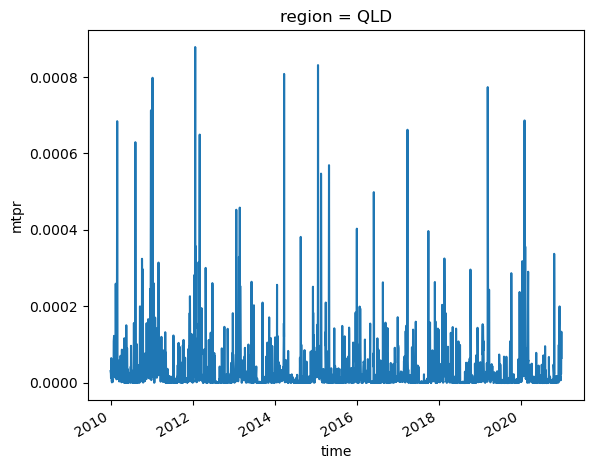

In [221]:
pred_ds.mtpr.sel(time=slice("2010", "2020")).plot()

## Prepare data

In [224]:
# time_cols = ["is_weekend", "month_sin", "month_cos"]
# time_cols = ["is_weekend", "month_int"]
# time_cols = ["is_weekend", "season_int"]
# time_cols = ["is_weekend", "is_transition"]
# time_cols = ["is_weekend"]
time_cols = []

region_dfs = {}
for region in dem_da.region.values:
    df = fn.to_dataframe(dem_da, pred_ds, region)
    for t in time_cols:
        df = fn.add_time_column(df, t)
    new_cols = np.append(np.append("demand", time_cols), df.columns[:-(len(time_cols) + 1)])
    df = df[new_cols]
    region_dfs[region] = df

In [225]:
# region_dfs[region]["year"] = region_dfs[region].index.year

In [226]:
region_dfs[region]

,demand,mtpr,w10,msdwswrf,rh,cdd3,t2m4,t2min,t2max,hdd4,q,cdd4,hdd,cdd,t2m3,hdd3,t2m
2010-01-01,141770.410,0.000030,2.552129,188.537223,78.151580,0.738437,297.767957,295.019211,300.196507,-0.021746,15.521469,0.735005,-0.021779,0.940108,297.772190,-0.021732,298.021588
2010-01-04,144340.325,0.000023,4.421680,185.918602,75.317741,1.218860,298.125030,294.611936,299.160990,-0.021426,13.984067,1.149150,-0.020322,0.378463,298.159532,-0.021302,296.930894
2010-01-05,138618.890,0.000012,3.157716,206.705011,76.112122,0.660630,297.917533,294.604593,299.870778,-0.021429,14.369416,1.019436,-0.021792,0.421253,297.473475,-0.021305,297.191601
2010-01-06,143681.465,0.000029,2.038874,208.815867,81.773821,0.514121,297.572390,294.916789,300.346237,-0.021432,16.081296,0.681145,-0.021795,0.742778,297.330459,-0.021308,297.869216
2010-01-07,137524.795,0.000064,2.782344,188.723075,80.033774,0.567043,297.375267,294.578332,299.849925,-0.021435,15.393444,0.519876,-0.021798,0.537229,297.523424,-0.021801,297.509766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,148768.235,0.000013,2.486152,211.272039,69.763327,1.139510,298.167499,293.829845,299.506734,-0.034371,12.941602,1.310093,-0.034363,0.493329,297.894447,-0.034368,296.839973
2020-12-25,134403.945,0.000023,2.871302,215.794536,70.951552,0.486094,297.506978,293.021286,299.447040,-0.034374,12.732811,0.901346,-0.034365,0.186995,296.949395,-0.034371,296.344701
2020-12-28,149172.215,0.000022,2.401874,312.369659,69.068987,0.478649,296.848768,294.192249,301.985113,-0.034106,13.768882,0.405701,-0.034375,0.897049,297.016834,-0.034010,298.049777
2020-12-29,158935.650,0.000123,1.798015,166.927440,77.786538,0.705400,297.247381,294.414971,300.282527,-0.034109,15.434386,0.570611,-0.034378,0.846638,297.669463,-0.034384,297.939161


### Subselect predictors if desired

In [227]:
region_dfs[region] = region_dfs[region][["demand", "hdd", "cdd"]]

In [228]:
region_dfs[region].head()

,demand,hdd,cdd
2010-01-01,141770.410,-0.021779,0.940108
2010-01-04,144340.325,-0.020322,0.378463
2010-01-05,138618.890,-0.021792,0.421253
2010-01-06,143681.465,-0.021795,0.742778
2010-01-07,137524.795,-0.021798,0.537229


## Split data into training and testing

Using this as a guide: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

As this is time series data, leave out the last two years for testing.

In [229]:
first_train_year = 2017
last_train_year = 2019

In [230]:
first_test_year = 2020
last_test_year = 2020

In [231]:
# Hold out last two years for testing
test_len = dem_da.sel(time=slice(str(first_test_year), str(last_test_year))).time.values.shape[0]

In [232]:
train_X, test_X, train_y, test_y = fn.split(
    fn.sel_train_test(region_dfs[region], first_train_year, last_test_year),
    "demand",
    test_size=test_len,
    random_state=0,
    shuffle=False
)

In [233]:
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(782, 2) (261, 2) (782,) (261,)


## Sequential feature selection

Chooses the predictors using forwards selection and a stopping criterion for a score.

In [234]:
# rf = RandomForestRegressor(
#     n_estimators=best_params["n_estimators"],
#     random_state=0
# )

In [235]:
rf = ExtraTreesRegressor(
    random_state=0
)

In [236]:
logo = fn.leave_one_group_out(
    train_X,
    train_y,
    dem_da.sel(time=slice(str(first_train_year), str(last_train_year))),
    str(first_train_year),
    str(last_train_year)
)

[2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 2017 

In [237]:
%%time
model = fn.mlextend_sfs(train_X, train_y, rf, list(logo), True, scoring="neg_mean_absolute_error")

CPU times: user 1.42 s, sys: 121 ms, total: 1.54 s
Wall time: 2.16 s


In [238]:
model.subsets_

{1: {'feature_idx': (1,),
  'cv_scores': array([-8217.42324365, -8196.83536226, -8681.00135383]),
  'avg_score': -8365.086653248603,
  'feature_names': ('1',)},
 2: {'feature_idx': (0, 1),
  'cv_scores': array([-7747.82690923, -6926.98999349, -8405.48370134]),
  'avg_score': -7693.433534686127,
  'feature_names': ('0', '1')}}

In [239]:
model.k_feature_idx_

(0, 1)

In [240]:
selected_features = list(region_dfs[region].columns[1:][list(model.k_feature_idx_)])
print(selected_features)

['hdd', 'cdd']


In [241]:
pd.DataFrame.from_dict(model.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(1,)","[-8217.423243653848, -8196.835362260555, -8681...",-8365.086653,"(1,)",503.046482,223.543491,158.069119
2,"(0, 1)","[-7747.826909230787, -6926.989993486596, -8405...",-7693.433535,"(0, 1)",1361.036816,604.816716,427.670001


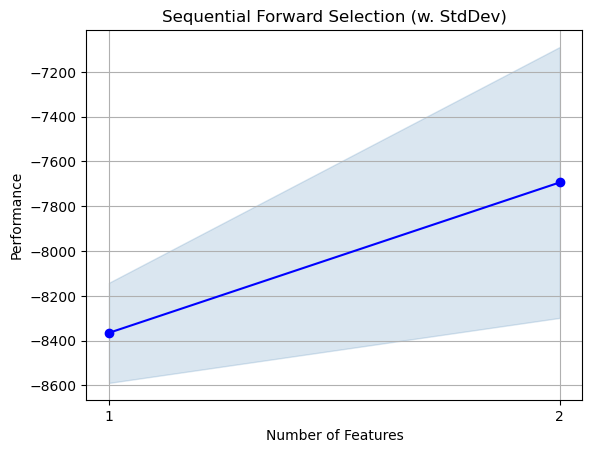

In [242]:
fig1 = plot_sfs(model.get_metric_dict(), kind='std_dev')
# plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

## Tune hyperparameters

Using leave one group out cross validation, where a group is a year.

In [243]:
parameters = {
    "n_estimators": randint(200, 500), # no. trees in the forest
    "min_samples_leaf": randint(5, 30), # min no. samples at leaf node
    "max_depth" : randint(5, 50), # max depth of each tree
    # "max_features" : uniform(0.2, 1) # max proportion of features to consider at split
    "max_leaf_nodes": randint(20, 200) # size of tree, how many end nodes
}

In [244]:
retain = ["demand"] + selected_features

In [245]:
final_features = region_dfs[region][retain]

In [246]:
final_features.head()

,demand,hdd,cdd
2010-01-01,141770.410,-0.021779,0.940108
2010-01-04,144340.325,-0.020322,0.378463
2010-01-05,138618.890,-0.021792,0.421253
2010-01-06,143681.465,-0.021795,0.742778
2010-01-07,137524.795,-0.021798,0.537229


In [247]:
train_X, test_X, train_y, test_y = fn.split(
    fn.sel_train_test(final_features, first_train_year, last_test_year),
    "demand",
    test_size=test_len,
    random_state=0,
    shuffle=False
)

In [248]:
# # very restricted space for testing
# parameters = {
#     "n_estimators": randint(10, 12), # no. trees in the forest
# }

In [249]:
rf = ExtraTreesRegressor()

In [250]:
logo = fn.leave_one_group_out(train_X, train_y, dem_da, str(first_train_year), str(last_train_year))

[2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 2017 

In [251]:
%%time
best_params = fn.tune_hyperparameters(
    train_X,
    train_y,
    rf,
    parameters,
    logo,
    n_iter=200
)

CPU times: user 3min 24s, sys: 16.5 s, total: 3min 41s
Wall time: 5min 7s


In [252]:
best_params

{'max_depth': 5,
 'max_leaf_nodes': 184,
 'min_samples_leaf': 5,
 'n_estimators': 470}

## Finalise model

In [253]:
rf = ExtraTreesRegressor(
    n_estimators=best_params["n_estimators"],
    min_samples_leaf=best_params["min_samples_leaf"],
    max_depth=best_params["max_depth"],
    max_leaf_nodes=best_params["max_leaf_nodes"],
    random_state=0,
)

In [254]:
model_train, pred_train = fn.predict_forest(train_y, train_X, train_X, rf)

In [255]:
model_test, pred_test = fn.predict_forest(train_y, train_X, test_X, rf)

In [256]:
pred_train.shape

(782,)

In [257]:
pred_test.shape

(261,)

## Evaluate performance

In [258]:
metric_names = ["R2", "MAE", "MSE", "MAPE", "MedAE"]
metrics = [r2_score, mean_absolute_error,
           mean_squared_error, mean_absolute_percentage_error, median_absolute_error]

In [259]:
train_scores = fn.compute_scores(train_y, pred_train, metrics)

In [260]:
train_scores

[0.39779156888988776,
 6694.714033097607,
 76686578.27450317,
 0.044204915948833384,
 5244.344059020223]

In [261]:
test_scores = fn.compute_scores(test_y, pred_test, metrics)

In [262]:
test_scores

[0.31740312487524613,
 9111.312712795012,
 123096708.90606093,
 0.062345312457374576,
 7804.74874645361]

In [263]:
def plot_scores(train, test, metric_names):
    """
    Subplot for each metric showing score for train and test.
    """
    fig, ax = plt.subplots(2, 3, figsize=(6, 3))
    for i, a in enumerate(ax.flatten()):
        if i < len(metric_names):
            a.bar(["Train", "Test"], [train[i], test[i]])
            a.set_title(metric_names[i])
    plt.tight_layout()

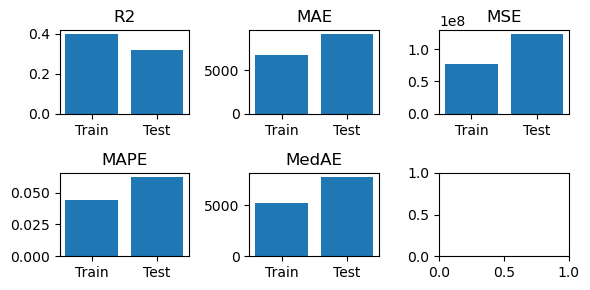

In [264]:
plot_scores(train_scores, test_scores, metric_names)

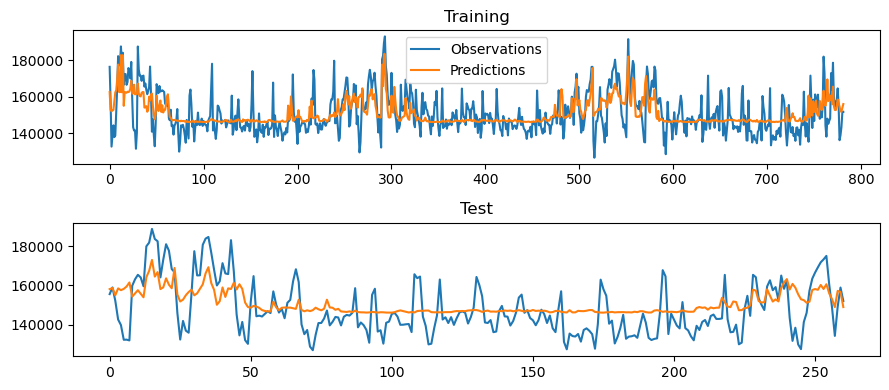

In [265]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4))

ax[0].plot(train_y, label="Observations")
ax[0].plot(pred_train, label="Predictions")
ax[0].legend()
ax[0].set_title("Training")

ax[1].plot(test_y)
ax[1].plot(pred_test)
ax[1].set_title("Test")

plt.tight_layout()

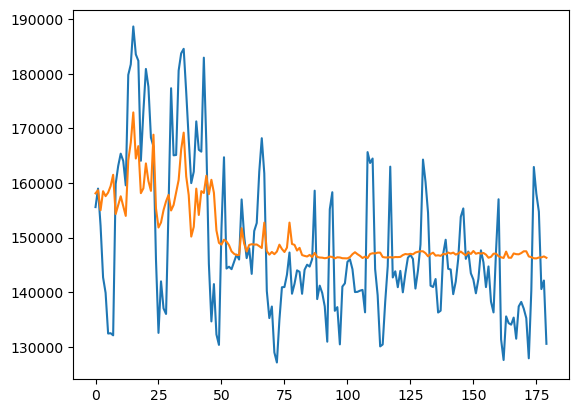

In [266]:
plt.plot(test_y[:180])
plt.plot(pred_test[:180])

## Permutation importances

Compute these on the training and test sets. Differences tell us what the model actually used to make the predictions.

In [78]:
perm_train = fn.perm_imp(
    model_train,
    train_X,
    train_y,
    n_repeats=200,
)

In [79]:
perm_test = fn.perm_imp(
    model_test,
    test_X,
    test_y,
    n_repeats=200,
)

In [80]:
perm_train

{'importances_mean': array([0.13995164, 0.01626925, 0.10572489, 0.07931434, 0.05082711,
        0.11471596, 0.02440561, 0.00493057, 0.03010124, 0.01219024]),
 'importances_std': array([0.00767917, 0.00085208, 0.00473147, 0.00350224, 0.00266331,
        0.00494296, 0.00123989, 0.00032476, 0.00184531, 0.00062019]),
 'importances': array([[0.13823381, 0.14006429, 0.13473595, ..., 0.14147323, 0.15898924,
         0.14590845],
        [0.01666628, 0.01584424, 0.01472775, ..., 0.01520337, 0.01683122,
         0.01746151],
        [0.09569864, 0.10335834, 0.11467901, ..., 0.10444087, 0.09852746,
         0.10132439],
        ...,
        [0.00420485, 0.00487804, 0.00512109, ..., 0.00493622, 0.00463681,
         0.00488321],
        [0.02698144, 0.03150382, 0.03180216, ..., 0.03053448, 0.0288593 ,
         0.03003869],
        [0.01080903, 0.01258779, 0.01293996, ..., 0.01263043, 0.01205979,
         0.01205937]])}

In [81]:
perm_test

{'importances_mean': array([0.07746051, 0.00150864, 0.11290801, 0.06718211, 0.01717762,
        0.11936247, 0.00826919, 0.00018062, 0.02204301, 0.00619968]),
 'importances_std': array([0.00894955, 0.00101213, 0.00718671, 0.00447685, 0.00376282,
        0.00779727, 0.00141239, 0.00031644, 0.00335353, 0.00105301]),
 'importances': array([[ 7.85418244e-02,  7.94944138e-02,  7.75581507e-02, ...,
          7.40198859e-02,  7.20541268e-02,  7.35219301e-02],
        [ 2.74295163e-03,  1.16625889e-03, -9.18489994e-05, ...,
          2.88342405e-03,  1.37960546e-03,  1.84245141e-03],
        [ 1.17367972e-01,  1.15038405e-01,  1.17089528e-01, ...,
          9.82815625e-02,  9.94207390e-02,  1.18130334e-01],
        ...,
        [-4.57788609e-04,  3.76797985e-04, -3.18489614e-05, ...,
          4.30664278e-04,  1.58781701e-04,  4.43500560e-04],
        [ 2.41954804e-02,  2.37801136e-02,  2.25581075e-02, ...,
          2.06896959e-02,  2.22267538e-02,  2.19887514e-02],
        [ 7.13391174e-03,  

In [82]:
fn.print_perm_imp(perm_train, selected_features)

is_weekend 0.140 +/- 0.008
t2max    0.115 +/- 0.005
t2m      0.106 +/- 0.005
t2m3     0.079 +/- 0.004
w10      0.051 +/- 0.003
cdd3     0.030 +/- 0.002
msdwswrf 0.024 +/- 0.001
q        0.016 +/- 0.001
cdd4     0.012 +/- 0.001
mtpr     0.005 +/- 0.000


In [83]:
fn.print_perm_imp(perm_test, selected_features)

t2max    0.119 +/- 0.008
t2m      0.113 +/- 0.007
is_weekend 0.077 +/- 0.009
t2m3     0.067 +/- 0.004
cdd3     0.022 +/- 0.003
w10      0.017 +/- 0.004
msdwswrf 0.008 +/- 0.001
cdd4     0.006 +/- 0.001
